In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)

import tensorflow.keras
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Bidirectional, GlobalMaxPool1D

from keras import callbacks 
from keras.constraints import maxnorm
import keras
from sklearn.model_selection import KFold

In [2]:
#retrieve data
num = 4000 # number of profiles
nvza = 12 # number of channels
nsza=6

s = 82 # output slice size
ts = 82 # input slice size 

In [3]:
#get the averaged reflectance from the dataset 
r=np.load('all_angles_r.npy')
c=np.load('cot_500m.npy')

In [5]:
r.shape

(4000, 82, 6, 12)

In [6]:
r=r.reshape((4000,82,72))

In [7]:
c.shape

(4000, 82)

In [8]:
r,c= shuffle(r, c, random_state=0)#Shuffle arrays in a consistent way.

#train test split
trp = 0.8; # 80 percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size #20% for testing:0.20*4000=800
print("train_size:",train_size,'profiles')
print("test_size:",test_size,'profiles')





train_size: 3200 profiles
test_size: 800 profiles


In [9]:
import os
checkpoint_path = "training_all_lstm/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [9]:
keras.utils.plot_model(model, show_shapes=True,show_layer_names=True,expand_nested=True,rankdir='TB')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [13]:
#Bi-LSTM model-------------------------------------------------------------------------------------------------
def eval_model(train_image, test_image, train_label, test_label):
    ltype = 'mean_squared_error'
    type2=tf.keras.metrics.RootMeanSquaredError()

    bsize = 16
    eps = 4000

    input_layer = tf.keras.layers.Input(shape=(ts,72),name='Input')
    
    lstm=tf.keras.layers.LSTM(units=64, activation='tanh',return_sequences = True,input_shape=(ts,72))(input_layer) 
    lstm=tf.keras.layers.LSTM(units=64, activation='tanh',return_sequences = True)(lstm) 
    lstm=tf.keras.layers.LSTM(units=96, activation='tanh',return_sequences = True)(lstm) 
    flat=tf.keras.layers.Flatten()(lstm)

    output = tf.keras.layers.Dense(82,activation='relu')(flat)


    model = tf.keras.models.Model(inputs=input_layer, outputs=output)

    model.compile(optimizer='adam',loss='mse',metrics=[ltype,type2])

    model.summary()


    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                                mode ="min", patience = 25,  
                                                restore_best_weights = True,
                                               verbose=1) 
    
    
     # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

    history = model.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.25,
                              callbacks =[earlystopping,cp_callback])

    # test and predict ---------------------------------------------------------------------------------------

    print('test result')
    results = model.evaluate(test_image, test_label)
    predictions=model.predict(test_image)

    mse = results[1]
    rmse = results[2]

    return model,rmse,mse,history,predictions

In [14]:
n_folds=5

kf = KFold(n_splits=n_folds,random_state=None, shuffle=False)
print(kf.get_n_splits(r))
print(kf)
ratio=int(r.shape[0]/n_folds) #800

X_train=np.zeros((5,800*4,ts,72))
y_train=np.zeros((5,ratio*(n_folds-1),82))
X_test=np.zeros((n_folds,ratio,82,72))
y_test=np.zeros((n_folds,ratio,82))

count=0
for train_index, test_index in kf.split(r):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train[count], X_test[count] = r[train_index], r[test_index]
    y_train[count], y_test[count] = c[train_index], c[test_index]
    count+=1

5
KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 800  801  802 ... 3997 3998 3999] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 

TRAIN: [   0    1    2 ... 3997 3998 3999] TEST: [2400 2401 2402 2403 2404 2405 2406 2407 2408 2409 2410 2411 2412 2413
 2414 2415 2416 2417 2418 2419 2420 2421 2422 2423 2424 2425 2426 2427
 2428 2429 2430 2431 2432 2433 2434 2435 2436 2437 2438 2439 2440 2441
 2442 2443 2444 2445 2446 2447 2448 2449 2450 2451 2452 2453 2454 2455
 2456 2457 2458 2459 2460 2461 2462 2463 2464 2465 2466 2467 2468 2469
 2470 2471 2472 2473 2474 2475 2476 2477 2478 2479 2480 2481 2482 2483
 2484 2485 2486 2487 2488 2489 2490 2491 2492 2493 2494 2495 2496 2497
 2498 2499 2500 2501 2502 2503 2504 2505 2506 2507 2508 2509 2510 2511
 2512 2513 2514 2515 2516 2517 2518 2519 2520 2521 2522 2523 2524 2525
 2526 2527 2528 2529 2530 2531 2532 2533 2534 2535 2536 2537 2538 2539
 2540 2541 2542 2543 2544 2545 2546 2547 2548 2549 2550 2551 2552 2553
 2554 2555 2556 2557 2558 2559 2560 2561 2562 2563 2564 2565 2566 2567
 2568 2569 2570 2571 2572 2573 2574 2575 2576 2577 2578 2579 2580 2581
 2582 2583 2584 2585 2586 25

In [15]:
# evaluate model----------------------------------------------------------------------------------------------
cv_scores = list()
cv_scores2 = list()

for n in range(n_folds):
        # split data    
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
        # evaluate model
    model,rmse,mse,history,predictions= eval_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
    print('RMSE on test set in fold'+str(n+1)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 82, 72)]          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 82, 64)            35072     
_________________________________________________________________
lstm_4 (LSTM)                (None, 82, 64)            33024     
_________________________________________________________________
lstm_5 (LSTM)                (None, 82, 96)            61824     
_________________________________________________________________
flatten_1 (Flatten)          (None, 7872)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 82)                645586    
Total params: 775,506
Trainable params: 775,506
Non-trainable params: 0
_____________________________________________________

150/150 [==============================] - 2s 15ms/step - loss: 0.4102 - mean_squared_error: 0.4102 - root_mean_squared_error: 0.6404 - val_loss: 0.4646 - val_mean_squared_error: 0.4646 - val_root_mean_squared_error: 0.6816

Epoch 00025: saving model to training_all_lstm\cp.ckpt
Epoch 26/4000
150/150 [==============================] - 2s 16ms/step - loss: 0.3625 - mean_squared_error: 0.3625 - root_mean_squared_error: 0.6018 - val_loss: 0.4552 - val_mean_squared_error: 0.4552 - val_root_mean_squared_error: 0.6747

Epoch 00026: saving model to training_all_lstm\cp.ckpt
Epoch 27/4000
150/150 [==============================] - 2s 16ms/step - loss: 0.3430 - mean_squared_error: 0.3430 - root_mean_squared_error: 0.5856 - val_loss: 0.4274 - val_mean_squared_error: 0.4274 - val_root_mean_squared_error: 0.6538

Epoch 00027: saving model to training_all_lstm\cp.ckpt
Epoch 28/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.3131 - mean_squared_error: 0.3131 - root_mean_square

150/150 [==============================] - 2s 16ms/step - loss: 0.1297 - mean_squared_error: 0.1297 - root_mean_squared_error: 0.3601 - val_loss: 0.1637 - val_mean_squared_error: 0.1637 - val_root_mean_squared_error: 0.4046

Epoch 00053: saving model to training_all_lstm\cp.ckpt
Epoch 54/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.1235 - mean_squared_error: 0.1235 - root_mean_squared_error: 0.3512 - val_loss: 0.1552 - val_mean_squared_error: 0.1552 - val_root_mean_squared_error: 0.3940

Epoch 00054: saving model to training_all_lstm\cp.ckpt
Epoch 55/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.1195 - mean_squared_error: 0.1195 - root_mean_squared_error: 0.3457 - val_loss: 0.2045 - val_mean_squared_error: 0.2045 - val_root_mean_squared_error: 0.4523

Epoch 00055: saving model to training_all_lstm\cp.ckpt
Epoch 56/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.1366 - mean_squared_error: 0.1366 - root_mean_square

150/150 [==============================] - 2s 16ms/step - loss: 0.0754 - mean_squared_error: 0.0754 - root_mean_squared_error: 0.2745 - val_loss: 0.1203 - val_mean_squared_error: 0.1203 - val_root_mean_squared_error: 0.3469

Epoch 00081: saving model to training_all_lstm\cp.ckpt
Epoch 82/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0745 - mean_squared_error: 0.0745 - root_mean_squared_error: 0.2729 - val_loss: 0.1284 - val_mean_squared_error: 0.1284 - val_root_mean_squared_error: 0.3584

Epoch 00082: saving model to training_all_lstm\cp.ckpt
Epoch 83/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0765 - mean_squared_error: 0.0765 - root_mean_squared_error: 0.2765 - val_loss: 0.1051 - val_mean_squared_error: 0.1051 - val_root_mean_squared_error: 0.3242

Epoch 00083: saving model to training_all_lstm\cp.ckpt
Epoch 84/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0608 - mean_squared_error: 0.0608 - root_mean_square

150/150 [==============================] - 2s 15ms/step - loss: 0.0551 - mean_squared_error: 0.0551 - root_mean_squared_error: 0.2347 - val_loss: 0.0996 - val_mean_squared_error: 0.0996 - val_root_mean_squared_error: 0.3156

Epoch 00109: saving model to training_all_lstm\cp.ckpt
Epoch 110/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0564 - mean_squared_error: 0.0564 - root_mean_squared_error: 0.2375 - val_loss: 0.0920 - val_mean_squared_error: 0.0920 - val_root_mean_squared_error: 0.3033

Epoch 00110: saving model to training_all_lstm\cp.ckpt
Epoch 111/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0540 - mean_squared_error: 0.0540 - root_mean_squared_error: 0.2324 - val_loss: 0.0883 - val_mean_squared_error: 0.0883 - val_root_mean_squared_error: 0.2972

Epoch 00111: saving model to training_all_lstm\cp.ckpt
Epoch 112/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0520 - mean_squared_error: 0.0520 - root_mean_squ

150/150 [==============================] - 2s 15ms/step - loss: 0.0433 - mean_squared_error: 0.0433 - root_mean_squared_error: 0.2080 - val_loss: 0.0782 - val_mean_squared_error: 0.0782 - val_root_mean_squared_error: 0.2797

Epoch 00137: saving model to training_all_lstm\cp.ckpt
Epoch 138/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0403 - mean_squared_error: 0.0403 - root_mean_squared_error: 0.2008 - val_loss: 0.0800 - val_mean_squared_error: 0.0800 - val_root_mean_squared_error: 0.2828

Epoch 00138: saving model to training_all_lstm\cp.ckpt
Epoch 139/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0372 - mean_squared_error: 0.0372 - root_mean_squared_error: 0.1929 - val_loss: 0.0786 - val_mean_squared_error: 0.0786 - val_root_mean_squared_error: 0.2804

Epoch 00139: saving model to training_all_lstm\cp.ckpt
Epoch 140/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0396 - mean_squared_error: 0.0396 - root_mean_squ

150/150 [==============================] - 2s 15ms/step - loss: 0.0306 - mean_squared_error: 0.0306 - root_mean_squared_error: 0.1749 - val_loss: 0.0882 - val_mean_squared_error: 0.0882 - val_root_mean_squared_error: 0.2971

Epoch 00165: saving model to training_all_lstm\cp.ckpt
Epoch 166/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0320 - mean_squared_error: 0.0320 - root_mean_squared_error: 0.1786 - val_loss: 0.0745 - val_mean_squared_error: 0.0745 - val_root_mean_squared_error: 0.2729

Epoch 00166: saving model to training_all_lstm\cp.ckpt
Epoch 167/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0297 - mean_squared_error: 0.0297 - root_mean_squared_error: 0.1723 - val_loss: 0.0806 - val_mean_squared_error: 0.0806 - val_root_mean_squared_error: 0.2840

Epoch 00167: saving model to training_all_lstm\cp.ckpt
Epoch 168/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - root_mean_squ

150/150 [==============================] - 2s 15ms/step - loss: 0.0215 - mean_squared_error: 0.0215 - root_mean_squared_error: 0.1467 - val_loss: 0.0691 - val_mean_squared_error: 0.0691 - val_root_mean_squared_error: 0.2628

Epoch 00193: saving model to training_all_lstm\cp.ckpt
Epoch 194/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0217 - mean_squared_error: 0.0217 - root_mean_squared_error: 0.1473 - val_loss: 0.0923 - val_mean_squared_error: 0.0923 - val_root_mean_squared_error: 0.3038

Epoch 00194: saving model to training_all_lstm\cp.ckpt
Epoch 195/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0332 - mean_squared_error: 0.0332 - root_mean_squared_error: 0.1819 - val_loss: 0.0694 - val_mean_squared_error: 0.0694 - val_root_mean_squared_error: 0.2634

Epoch 00195: saving model to training_all_lstm\cp.ckpt
Epoch 196/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0249 - mean_squared_error: 0.0249 - root_mean_squ

150/150 [==============================] - 2s 15ms/step - loss: 0.0199 - mean_squared_error: 0.0199 - root_mean_squared_error: 0.1409 - val_loss: 0.0769 - val_mean_squared_error: 0.0769 - val_root_mean_squared_error: 0.2774

Epoch 00221: saving model to training_all_lstm\cp.ckpt
Epoch 222/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - root_mean_squared_error: 0.1488 - val_loss: 0.0748 - val_mean_squared_error: 0.0748 - val_root_mean_squared_error: 0.2735

Epoch 00222: saving model to training_all_lstm\cp.ckpt
Epoch 223/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0203 - mean_squared_error: 0.0203 - root_mean_squared_error: 0.1425 - val_loss: 0.0692 - val_mean_squared_error: 0.0692 - val_root_mean_squared_error: 0.2631

Epoch 00223: saving model to training_all_lstm\cp.ckpt
Epoch 224/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0181 - mean_squared_error: 0.0181 - root_mean_squ

150/150 [==============================] - 2s 15ms/step - loss: 2.0246 - mean_squared_error: 2.0246 - root_mean_squared_error: 1.4229 - val_loss: 2.0420 - val_mean_squared_error: 2.0420 - val_root_mean_squared_error: 1.4290

Epoch 00014: saving model to training_all_lstm\cp.ckpt
Epoch 15/4000
150/150 [==============================] - 2s 15ms/step - loss: 1.6637 - mean_squared_error: 1.6637 - root_mean_squared_error: 1.2898 - val_loss: 1.8235 - val_mean_squared_error: 1.8235 - val_root_mean_squared_error: 1.3504

Epoch 00015: saving model to training_all_lstm\cp.ckpt
Epoch 16/4000
150/150 [==============================] - 2s 15ms/step - loss: 1.3954 - mean_squared_error: 1.3954 - root_mean_squared_error: 1.1811 - val_loss: 1.4074 - val_mean_squared_error: 1.4074 - val_root_mean_squared_error: 1.1863

Epoch 00016: saving model to training_all_lstm\cp.ckpt
Epoch 17/4000
150/150 [==============================] - 2s 15ms/step - loss: 1.1315 - mean_squared_error: 1.1315 - root_mean_square

150/150 [==============================] - 2s 17ms/step - loss: 0.2166 - mean_squared_error: 0.2166 - root_mean_squared_error: 0.4654 - val_loss: 0.2511 - val_mean_squared_error: 0.2511 - val_root_mean_squared_error: 0.5011

Epoch 00042: saving model to training_all_lstm\cp.ckpt
Epoch 43/4000
150/150 [==============================] - 3s 18ms/step - loss: 0.1972 - mean_squared_error: 0.1972 - root_mean_squared_error: 0.4440 - val_loss: 0.2428 - val_mean_squared_error: 0.2428 - val_root_mean_squared_error: 0.4927

Epoch 00043: saving model to training_all_lstm\cp.ckpt
Epoch 44/4000
150/150 [==============================] - 2s 16ms/step - loss: 0.1963 - mean_squared_error: 0.1963 - root_mean_squared_error: 0.4429 - val_loss: 0.2465 - val_mean_squared_error: 0.2465 - val_root_mean_squared_error: 0.4965

Epoch 00044: saving model to training_all_lstm\cp.ckpt
Epoch 45/4000
150/150 [==============================] - 2s 16ms/step - loss: 0.2093 - mean_squared_error: 0.2093 - root_mean_square

150/150 [==============================] - 2s 16ms/step - loss: 0.1074 - mean_squared_error: 0.1074 - root_mean_squared_error: 0.3276 - val_loss: 0.1622 - val_mean_squared_error: 0.1622 - val_root_mean_squared_error: 0.4027

Epoch 00070: saving model to training_all_lstm\cp.ckpt
Epoch 71/4000
150/150 [==============================] - 2s 16ms/step - loss: 0.1017 - mean_squared_error: 0.1017 - root_mean_squared_error: 0.3188 - val_loss: 0.1390 - val_mean_squared_error: 0.1390 - val_root_mean_squared_error: 0.3728

Epoch 00071: saving model to training_all_lstm\cp.ckpt
Epoch 72/4000
150/150 [==============================] - 2s 16ms/step - loss: 0.0904 - mean_squared_error: 0.0904 - root_mean_squared_error: 0.3005 - val_loss: 0.1575 - val_mean_squared_error: 0.1575 - val_root_mean_squared_error: 0.3968

Epoch 00072: saving model to training_all_lstm\cp.ckpt
Epoch 73/4000
150/150 [==============================] - 2s 16ms/step - loss: 0.1080 - mean_squared_error: 0.1080 - root_mean_square

150/150 [==============================] - 3s 17ms/step - loss: 0.0677 - mean_squared_error: 0.0677 - root_mean_squared_error: 0.2602 - val_loss: 0.1000 - val_mean_squared_error: 0.1000 - val_root_mean_squared_error: 0.3163

Epoch 00098: saving model to training_all_lstm\cp.ckpt
Epoch 99/4000
150/150 [==============================] - 2s 16ms/step - loss: 0.0551 - mean_squared_error: 0.0551 - root_mean_squared_error: 0.2347 - val_loss: 0.0998 - val_mean_squared_error: 0.0998 - val_root_mean_squared_error: 0.3159

Epoch 00099: saving model to training_all_lstm\cp.ckpt
Epoch 100/4000
150/150 [==============================] - 2s 16ms/step - loss: 0.0744 - mean_squared_error: 0.0744 - root_mean_squared_error: 0.2727 - val_loss: 0.0993 - val_mean_squared_error: 0.0993 - val_root_mean_squared_error: 0.3151

Epoch 00100: saving model to training_all_lstm\cp.ckpt
Epoch 101/4000
150/150 [==============================] - 2s 16ms/step - loss: 0.0568 - mean_squared_error: 0.0568 - root_mean_squa

150/150 [==============================] - 2s 15ms/step - loss: 0.0519 - mean_squared_error: 0.0519 - root_mean_squared_error: 0.2278 - val_loss: 0.0854 - val_mean_squared_error: 0.0854 - val_root_mean_squared_error: 0.2923

Epoch 00126: saving model to training_all_lstm\cp.ckpt
Epoch 127/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0418 - mean_squared_error: 0.0418 - root_mean_squared_error: 0.2044 - val_loss: 0.0827 - val_mean_squared_error: 0.0827 - val_root_mean_squared_error: 0.2875

Epoch 00127: saving model to training_all_lstm\cp.ckpt
Epoch 128/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0463 - mean_squared_error: 0.0463 - root_mean_squared_error: 0.2151 - val_loss: 0.0824 - val_mean_squared_error: 0.0824 - val_root_mean_squared_error: 0.2871

Epoch 00128: saving model to training_all_lstm\cp.ckpt
Epoch 129/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0409 - mean_squared_error: 0.0409 - root_mean_squ

150/150 [==============================] - 2s 16ms/step - loss: 0.0502 - mean_squared_error: 0.0502 - root_mean_squared_error: 0.2238 - val_loss: 0.0714 - val_mean_squared_error: 0.0714 - val_root_mean_squared_error: 0.2673

Epoch 00154: saving model to training_all_lstm\cp.ckpt
Epoch 155/4000
150/150 [==============================] - 2s 16ms/step - loss: 0.0335 - mean_squared_error: 0.0335 - root_mean_squared_error: 0.1831 - val_loss: 0.0674 - val_mean_squared_error: 0.0674 - val_root_mean_squared_error: 0.2597

Epoch 00155: saving model to training_all_lstm\cp.ckpt
Epoch 156/4000
150/150 [==============================] - 2s 16ms/step - loss: 0.0295 - mean_squared_error: 0.0295 - root_mean_squared_error: 0.1717 - val_loss: 0.0729 - val_mean_squared_error: 0.0729 - val_root_mean_squared_error: 0.2699

Epoch 00156: saving model to training_all_lstm\cp.ckpt
Epoch 157/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0336 - mean_squared_error: 0.0336 - root_mean_squ

150/150 [==============================] - 2s 15ms/step - loss: 0.0317 - mean_squared_error: 0.0317 - root_mean_squared_error: 0.1780 - val_loss: 0.0678 - val_mean_squared_error: 0.0678 - val_root_mean_squared_error: 0.2604

Epoch 00182: saving model to training_all_lstm\cp.ckpt
Epoch 183/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0270 - mean_squared_error: 0.0270 - root_mean_squared_error: 0.1643 - val_loss: 0.0704 - val_mean_squared_error: 0.0704 - val_root_mean_squared_error: 0.2654

Epoch 00183: saving model to training_all_lstm\cp.ckpt
Epoch 184/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0262 - mean_squared_error: 0.0262 - root_mean_squared_error: 0.1620 - val_loss: 0.0692 - val_mean_squared_error: 0.0692 - val_root_mean_squared_error: 0.2631

Epoch 00184: saving model to training_all_lstm\cp.ckpt
Epoch 185/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0300 - mean_squared_error: 0.0300 - root_mean_squ

150/150 [==============================] - 2s 15ms/step - loss: 15.5789 - mean_squared_error: 15.5789 - root_mean_squared_error: 3.9456 - val_loss: 12.3440 - val_mean_squared_error: 12.3440 - val_root_mean_squared_error: 3.5134

Epoch 00003: saving model to training_all_lstm\cp.ckpt
Epoch 4/4000
150/150 [==============================] - 2s 15ms/step - loss: 11.6277 - mean_squared_error: 11.6277 - root_mean_squared_error: 3.4097 - val_loss: 10.0742 - val_mean_squared_error: 10.0742 - val_root_mean_squared_error: 3.1740

Epoch 00004: saving model to training_all_lstm\cp.ckpt
Epoch 5/4000
150/150 [==============================] - 2s 16ms/step - loss: 9.4511 - mean_squared_error: 9.4511 - root_mean_squared_error: 3.0740 - val_loss: 7.9083 - val_mean_squared_error: 7.9083 - val_root_mean_squared_error: 2.8122

Epoch 00005: saving model to training_all_lstm\cp.ckpt
Epoch 6/4000
150/150 [==============================] - 2s 15ms/step - loss: 7.4054 - mean_squared_error: 7.4054 - root_mean_s

150/150 [==============================] - 2s 15ms/step - loss: 0.2658 - mean_squared_error: 0.2658 - root_mean_squared_error: 0.5155 - val_loss: 0.4484 - val_mean_squared_error: 0.4484 - val_root_mean_squared_error: 0.6696

Epoch 00031: saving model to training_all_lstm\cp.ckpt
Epoch 32/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.2796 - mean_squared_error: 0.2796 - root_mean_squared_error: 0.5288 - val_loss: 0.3183 - val_mean_squared_error: 0.3183 - val_root_mean_squared_error: 0.5642

Epoch 00032: saving model to training_all_lstm\cp.ckpt
Epoch 33/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.2788 - mean_squared_error: 0.2788 - root_mean_squared_error: 0.5279 - val_loss: 0.3905 - val_mean_squared_error: 0.3905 - val_root_mean_squared_error: 0.6249

Epoch 00033: saving model to training_all_lstm\cp.ckpt
Epoch 34/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.2826 - mean_squared_error: 0.2826 - root_mean_square

150/150 [==============================] - 2s 15ms/step - loss: 0.1237 - mean_squared_error: 0.1237 - root_mean_squared_error: 0.3516 - val_loss: 0.1638 - val_mean_squared_error: 0.1638 - val_root_mean_squared_error: 0.4048

Epoch 00059: saving model to training_all_lstm\cp.ckpt
Epoch 60/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.1087 - mean_squared_error: 0.1087 - root_mean_squared_error: 0.3297 - val_loss: 0.1625 - val_mean_squared_error: 0.1625 - val_root_mean_squared_error: 0.4031

Epoch 00060: saving model to training_all_lstm\cp.ckpt
Epoch 61/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.1073 - mean_squared_error: 0.1073 - root_mean_squared_error: 0.3275 - val_loss: 0.1873 - val_mean_squared_error: 0.1873 - val_root_mean_squared_error: 0.4327

Epoch 00061: saving model to training_all_lstm\cp.ckpt
Epoch 62/4000
150/150 [==============================] - 2s 16ms/step - loss: 0.1207 - mean_squared_error: 0.1207 - root_mean_square

150/150 [==============================] - 2s 16ms/step - loss: 0.0700 - mean_squared_error: 0.0700 - root_mean_squared_error: 0.2645 - val_loss: 0.1164 - val_mean_squared_error: 0.1164 - val_root_mean_squared_error: 0.3411

Epoch 00087: saving model to training_all_lstm\cp.ckpt
Epoch 88/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0769 - mean_squared_error: 0.0769 - root_mean_squared_error: 0.2772 - val_loss: 0.1073 - val_mean_squared_error: 0.1073 - val_root_mean_squared_error: 0.3275

Epoch 00088: saving model to training_all_lstm\cp.ckpt
Epoch 89/4000
150/150 [==============================] - 2s 16ms/step - loss: 0.0614 - mean_squared_error: 0.0614 - root_mean_squared_error: 0.2477 - val_loss: 0.1084 - val_mean_squared_error: 0.1084 - val_root_mean_squared_error: 0.3293

Epoch 00089: saving model to training_all_lstm\cp.ckpt
Epoch 90/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0635 - mean_squared_error: 0.0635 - root_mean_square

150/150 [==============================] - 2s 16ms/step - loss: 0.0540 - mean_squared_error: 0.0540 - root_mean_squared_error: 0.2322 - val_loss: 0.0935 - val_mean_squared_error: 0.0935 - val_root_mean_squared_error: 0.3057

Epoch 00115: saving model to training_all_lstm\cp.ckpt
Epoch 116/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0507 - mean_squared_error: 0.0507 - root_mean_squared_error: 0.2252 - val_loss: 0.0828 - val_mean_squared_error: 0.0828 - val_root_mean_squared_error: 0.2878

Epoch 00116: saving model to training_all_lstm\cp.ckpt
Epoch 117/4000
150/150 [==============================] - 2s 16ms/step - loss: 0.0474 - mean_squared_error: 0.0474 - root_mean_squared_error: 0.2175 - val_loss: 0.1260 - val_mean_squared_error: 0.1260 - val_root_mean_squared_error: 0.3550

Epoch 00117: saving model to training_all_lstm\cp.ckpt
Epoch 118/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0727 - mean_squared_error: 0.0727 - root_mean_squ

150/150 [==============================] - 2s 17ms/step - loss: 0.0411 - mean_squared_error: 0.0411 - root_mean_squared_error: 0.2027 - val_loss: 0.0850 - val_mean_squared_error: 0.0850 - val_root_mean_squared_error: 0.2915

Epoch 00143: saving model to training_all_lstm\cp.ckpt
Epoch 144/4000
150/150 [==============================] - 2s 17ms/step - loss: 0.0353 - mean_squared_error: 0.0353 - root_mean_squared_error: 0.1878 - val_loss: 0.0775 - val_mean_squared_error: 0.0775 - val_root_mean_squared_error: 0.2784

Epoch 00144: saving model to training_all_lstm\cp.ckpt
Epoch 145/4000
150/150 [==============================] - 2s 17ms/step - loss: 0.0360 - mean_squared_error: 0.0360 - root_mean_squared_error: 0.1897 - val_loss: 0.1070 - val_mean_squared_error: 0.1070 - val_root_mean_squared_error: 0.3271

Epoch 00145: saving model to training_all_lstm\cp.ckpt
Epoch 146/4000
150/150 [==============================] - 2s 17ms/step - loss: 0.0554 - mean_squared_error: 0.0554 - root_mean_squ

150/150 [==============================] - 3s 17ms/step - loss: 0.0342 - mean_squared_error: 0.0342 - root_mean_squared_error: 0.1848 - val_loss: 0.0712 - val_mean_squared_error: 0.0712 - val_root_mean_squared_error: 0.2668

Epoch 00171: saving model to training_all_lstm\cp.ckpt
Epoch 172/4000
150/150 [==============================] - 3s 17ms/step - loss: 0.0298 - mean_squared_error: 0.0298 - root_mean_squared_error: 0.1726 - val_loss: 0.0798 - val_mean_squared_error: 0.0798 - val_root_mean_squared_error: 0.2825

Epoch 00172: saving model to training_all_lstm\cp.ckpt
Epoch 173/4000
150/150 [==============================] - 3s 17ms/step - loss: 0.0332 - mean_squared_error: 0.0332 - root_mean_squared_error: 0.1821 - val_loss: 0.0725 - val_mean_squared_error: 0.0725 - val_root_mean_squared_error: 0.2692

Epoch 00173: saving model to training_all_lstm\cp.ckpt
Epoch 174/4000
150/150 [==============================] - 3s 17ms/step - loss: 0.0283 - mean_squared_error: 0.0283 - root_mean_squ

150/150 [==============================] - 2s 16ms/step - loss: 0.0233 - mean_squared_error: 0.0233 - root_mean_squared_error: 0.1526 - val_loss: 0.0757 - val_mean_squared_error: 0.0757 - val_root_mean_squared_error: 0.2751

Epoch 00199: saving model to training_all_lstm\cp.ckpt
Epoch 200/4000
150/150 [==============================] - 2s 16ms/step - loss: 0.0286 - mean_squared_error: 0.0286 - root_mean_squared_error: 0.1690 - val_loss: 0.0678 - val_mean_squared_error: 0.0678 - val_root_mean_squared_error: 0.2605

Epoch 00200: saving model to training_all_lstm\cp.ckpt
Epoch 201/4000
150/150 [==============================] - 2s 16ms/step - loss: 0.0224 - mean_squared_error: 0.0224 - root_mean_squared_error: 0.1496 - val_loss: 0.0726 - val_mean_squared_error: 0.0726 - val_root_mean_squared_error: 0.2695

Epoch 00201: saving model to training_all_lstm\cp.ckpt
Epoch 202/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0257 - mean_squared_error: 0.0257 - root_mean_squ

150/150 [==============================] - 2s 16ms/step - loss: 2.2871 - mean_squared_error: 2.2871 - root_mean_squared_error: 1.5123 - val_loss: 2.3277 - val_mean_squared_error: 2.3277 - val_root_mean_squared_error: 1.5257

Epoch 00014: saving model to training_all_lstm\cp.ckpt
Epoch 15/4000
150/150 [==============================] - 2s 15ms/step - loss: 1.9336 - mean_squared_error: 1.9336 - root_mean_squared_error: 1.3905 - val_loss: 1.9222 - val_mean_squared_error: 1.9222 - val_root_mean_squared_error: 1.3864

Epoch 00015: saving model to training_all_lstm\cp.ckpt
Epoch 16/4000
150/150 [==============================] - 2s 15ms/step - loss: 1.6007 - mean_squared_error: 1.6007 - root_mean_squared_error: 1.2652 - val_loss: 1.7124 - val_mean_squared_error: 1.7124 - val_root_mean_squared_error: 1.3086

Epoch 00016: saving model to training_all_lstm\cp.ckpt
Epoch 17/4000
150/150 [==============================] - 2s 15ms/step - loss: 1.4355 - mean_squared_error: 1.4355 - root_mean_square

150/150 [==============================] - 2s 16ms/step - loss: 0.2196 - mean_squared_error: 0.2196 - root_mean_squared_error: 0.4680 - val_loss: 0.2396 - val_mean_squared_error: 0.2396 - val_root_mean_squared_error: 0.4895

Epoch 00042: saving model to training_all_lstm\cp.ckpt
Epoch 43/4000
150/150 [==============================] - 2s 16ms/step - loss: 0.2192 - mean_squared_error: 0.2192 - root_mean_squared_error: 0.4679 - val_loss: 0.2232 - val_mean_squared_error: 0.2232 - val_root_mean_squared_error: 0.4725

Epoch 00043: saving model to training_all_lstm\cp.ckpt
Epoch 44/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.1829 - mean_squared_error: 0.1829 - root_mean_squared_error: 0.4273 - val_loss: 0.2338 - val_mean_squared_error: 0.2338 - val_root_mean_squared_error: 0.4835

Epoch 00044: saving model to training_all_lstm\cp.ckpt
Epoch 45/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.1891 - mean_squared_error: 0.1891 - root_mean_square

150/150 [==============================] - 2s 16ms/step - loss: 0.1055 - mean_squared_error: 0.1055 - root_mean_squared_error: 0.3247 - val_loss: 0.1461 - val_mean_squared_error: 0.1461 - val_root_mean_squared_error: 0.3822

Epoch 00070: saving model to training_all_lstm\cp.ckpt
Epoch 71/4000
150/150 [==============================] - 3s 17ms/step - loss: 0.1017 - mean_squared_error: 0.1017 - root_mean_squared_error: 0.3189 - val_loss: 0.1433 - val_mean_squared_error: 0.1433 - val_root_mean_squared_error: 0.3785

Epoch 00071: saving model to training_all_lstm\cp.ckpt
Epoch 72/4000
150/150 [==============================] - 2s 17ms/step - loss: 0.0935 - mean_squared_error: 0.0935 - root_mean_squared_error: 0.3058 - val_loss: 0.1464 - val_mean_squared_error: 0.1464 - val_root_mean_squared_error: 0.3827

Epoch 00072: saving model to training_all_lstm\cp.ckpt
Epoch 73/4000
150/150 [==============================] - 2s 16ms/step - loss: 0.0936 - mean_squared_error: 0.0936 - root_mean_square

150/150 [==============================] - 2s 15ms/step - loss: 0.0538 - mean_squared_error: 0.0538 - root_mean_squared_error: 0.2319 - val_loss: 0.0885 - val_mean_squared_error: 0.0885 - val_root_mean_squared_error: 0.2975

Epoch 00098: saving model to training_all_lstm\cp.ckpt
Epoch 99/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0550 - mean_squared_error: 0.0550 - root_mean_squared_error: 0.2344 - val_loss: 0.0918 - val_mean_squared_error: 0.0918 - val_root_mean_squared_error: 0.3030

Epoch 00099: saving model to training_all_lstm\cp.ckpt
Epoch 100/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0543 - mean_squared_error: 0.0543 - root_mean_squared_error: 0.2329 - val_loss: 0.1022 - val_mean_squared_error: 0.1022 - val_root_mean_squared_error: 0.3196

Epoch 00100: saving model to training_all_lstm\cp.ckpt
Epoch 101/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0561 - mean_squared_error: 0.0561 - root_mean_squa

150/150 [==============================] - 3s 17ms/step - loss: 0.0386 - mean_squared_error: 0.0386 - root_mean_squared_error: 0.1963 - val_loss: 0.0866 - val_mean_squared_error: 0.0866 - val_root_mean_squared_error: 0.2943

Epoch 00126: saving model to training_all_lstm\cp.ckpt
Epoch 127/4000
150/150 [==============================] - 2s 16ms/step - loss: 0.0421 - mean_squared_error: 0.0421 - root_mean_squared_error: 0.2051 - val_loss: 0.0845 - val_mean_squared_error: 0.0845 - val_root_mean_squared_error: 0.2906

Epoch 00127: saving model to training_all_lstm\cp.ckpt
Epoch 128/4000
150/150 [==============================] - 2s 16ms/step - loss: 0.0419 - mean_squared_error: 0.0419 - root_mean_squared_error: 0.2047 - val_loss: 0.0783 - val_mean_squared_error: 0.0783 - val_root_mean_squared_error: 0.2799

Epoch 00128: saving model to training_all_lstm\cp.ckpt
Epoch 129/4000
150/150 [==============================] - 2s 17ms/step - loss: 0.0429 - mean_squared_error: 0.0429 - root_mean_squ

150/150 [==============================] - 2s 16ms/step - loss: 0.0310 - mean_squared_error: 0.0310 - root_mean_squared_error: 0.1760 - val_loss: 0.0814 - val_mean_squared_error: 0.0814 - val_root_mean_squared_error: 0.2853

Epoch 00154: saving model to training_all_lstm\cp.ckpt
Epoch 155/4000
150/150 [==============================] - 2s 16ms/step - loss: 0.0317 - mean_squared_error: 0.0317 - root_mean_squared_error: 0.1779 - val_loss: 0.1160 - val_mean_squared_error: 0.1160 - val_root_mean_squared_error: 0.3406

Epoch 00155: saving model to training_all_lstm\cp.ckpt
Epoch 156/4000
150/150 [==============================] - 2s 16ms/step - loss: 0.0451 - mean_squared_error: 0.0451 - root_mean_squared_error: 0.2118 - val_loss: 0.0783 - val_mean_squared_error: 0.0783 - val_root_mean_squared_error: 0.2798

Epoch 00156: saving model to training_all_lstm\cp.ckpt
Epoch 157/4000
150/150 [==============================] - 2s 16ms/step - loss: 0.0333 - mean_squared_error: 0.0333 - root_mean_squ

150/150 [==============================] - 2s 16ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - root_mean_squared_error: 0.1503 - val_loss: 0.0759 - val_mean_squared_error: 0.0759 - val_root_mean_squared_error: 0.2755

Epoch 00182: saving model to training_all_lstm\cp.ckpt
Epoch 183/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0280 - mean_squared_error: 0.0280 - root_mean_squared_error: 0.1672 - val_loss: 0.0770 - val_mean_squared_error: 0.0770 - val_root_mean_squared_error: 0.2775

Epoch 00183: saving model to training_all_lstm\cp.ckpt
Epoch 184/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0352 - mean_squared_error: 0.0352 - root_mean_squared_error: 0.1876 - val_loss: 0.0720 - val_mean_squared_error: 0.0720 - val_root_mean_squared_error: 0.2683

Epoch 00184: saving model to training_all_lstm\cp.ckpt
Epoch 185/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0262 - mean_squared_error: 0.0262 - root_mean_squ

150/150 [==============================] - 2s 15ms/step - loss: 15.5848 - mean_squared_error: 15.5848 - root_mean_squared_error: 3.9467 - val_loss: 12.0543 - val_mean_squared_error: 12.0543 - val_root_mean_squared_error: 3.4719

Epoch 00003: saving model to training_all_lstm\cp.ckpt
Epoch 4/4000
150/150 [==============================] - 2s 15ms/step - loss: 11.4113 - mean_squared_error: 11.4113 - root_mean_squared_error: 3.3777 - val_loss: 9.7079 - val_mean_squared_error: 9.7079 - val_root_mean_squared_error: 3.1158

Epoch 00004: saving model to training_all_lstm\cp.ckpt
Epoch 5/4000
150/150 [==============================] - 2s 15ms/step - loss: 8.9314 - mean_squared_error: 8.9314 - root_mean_squared_error: 2.9882 - val_loss: 7.7728 - val_mean_squared_error: 7.7728 - val_root_mean_squared_error: 2.7880

Epoch 00005: saving model to training_all_lstm\cp.ckpt
Epoch 6/4000
150/150 [==============================] - 2s 15ms/step - loss: 6.8928 - mean_squared_error: 6.8928 - root_mean_squ

150/150 [==============================] - 2s 16ms/step - loss: 0.3279 - mean_squared_error: 0.3279 - root_mean_squared_error: 0.5725 - val_loss: 0.4104 - val_mean_squared_error: 0.4104 - val_root_mean_squared_error: 0.6406

Epoch 00031: saving model to training_all_lstm\cp.ckpt
Epoch 32/4000
150/150 [==============================] - 2s 16ms/step - loss: 0.3213 - mean_squared_error: 0.3213 - root_mean_squared_error: 0.5667 - val_loss: 0.4779 - val_mean_squared_error: 0.4779 - val_root_mean_squared_error: 0.6913

Epoch 00032: saving model to training_all_lstm\cp.ckpt
Epoch 33/4000
150/150 [==============================] - 2s 16ms/step - loss: 0.3022 - mean_squared_error: 0.3022 - root_mean_squared_error: 0.5497 - val_loss: 0.3926 - val_mean_squared_error: 0.3926 - val_root_mean_squared_error: 0.6265

Epoch 00033: saving model to training_all_lstm\cp.ckpt
Epoch 34/4000
150/150 [==============================] - 2s 16ms/step - loss: 0.2915 - mean_squared_error: 0.2915 - root_mean_square

150/150 [==============================] - 2s 15ms/step - loss: 0.1338 - mean_squared_error: 0.1338 - root_mean_squared_error: 0.3650 - val_loss: 0.2310 - val_mean_squared_error: 0.2310 - val_root_mean_squared_error: 0.4806

Epoch 00059: saving model to training_all_lstm\cp.ckpt
Epoch 60/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.1353 - mean_squared_error: 0.1353 - root_mean_squared_error: 0.3677 - val_loss: 0.2057 - val_mean_squared_error: 0.2057 - val_root_mean_squared_error: 0.4535

Epoch 00060: saving model to training_all_lstm\cp.ckpt
Epoch 61/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.1607 - mean_squared_error: 0.1607 - root_mean_squared_error: 0.4005 - val_loss: 0.2130 - val_mean_squared_error: 0.2130 - val_root_mean_squared_error: 0.4615

Epoch 00061: saving model to training_all_lstm\cp.ckpt
Epoch 62/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.1374 - mean_squared_error: 0.1374 - root_mean_square

150/150 [==============================] - 2s 15ms/step - loss: 0.0734 - mean_squared_error: 0.0734 - root_mean_squared_error: 0.2710 - val_loss: 0.1266 - val_mean_squared_error: 0.1266 - val_root_mean_squared_error: 0.3559

Epoch 00087: saving model to training_all_lstm\cp.ckpt
Epoch 88/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0763 - mean_squared_error: 0.0763 - root_mean_squared_error: 0.2761 - val_loss: 0.1136 - val_mean_squared_error: 0.1136 - val_root_mean_squared_error: 0.3370

Epoch 00088: saving model to training_all_lstm\cp.ckpt
Epoch 89/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0722 - mean_squared_error: 0.0722 - root_mean_squared_error: 0.2685 - val_loss: 0.1271 - val_mean_squared_error: 0.1271 - val_root_mean_squared_error: 0.3566

Epoch 00089: saving model to training_all_lstm\cp.ckpt
Epoch 90/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0677 - mean_squared_error: 0.0677 - root_mean_square

150/150 [==============================] - 2s 15ms/step - loss: 0.0559 - mean_squared_error: 0.0559 - root_mean_squared_error: 0.2364 - val_loss: 0.1083 - val_mean_squared_error: 0.1083 - val_root_mean_squared_error: 0.3291

Epoch 00115: saving model to training_all_lstm\cp.ckpt
Epoch 116/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0525 - mean_squared_error: 0.0525 - root_mean_squared_error: 0.2290 - val_loss: 0.1045 - val_mean_squared_error: 0.1045 - val_root_mean_squared_error: 0.3232

Epoch 00116: saving model to training_all_lstm\cp.ckpt
Epoch 117/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0479 - mean_squared_error: 0.0479 - root_mean_squared_error: 0.2189 - val_loss: 0.0902 - val_mean_squared_error: 0.0902 - val_root_mean_squared_error: 0.3003

Epoch 00117: saving model to training_all_lstm\cp.ckpt
Epoch 118/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0440 - mean_squared_error: 0.0440 - root_mean_squ

150/150 [==============================] - 2s 15ms/step - loss: 0.0364 - mean_squared_error: 0.0364 - root_mean_squared_error: 0.1907 - val_loss: 0.1063 - val_mean_squared_error: 0.1063 - val_root_mean_squared_error: 0.3260

Epoch 00143: saving model to training_all_lstm\cp.ckpt
Epoch 144/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0461 - mean_squared_error: 0.0461 - root_mean_squared_error: 0.2147 - val_loss: 0.1014 - val_mean_squared_error: 0.1014 - val_root_mean_squared_error: 0.3185

Epoch 00144: saving model to training_all_lstm\cp.ckpt
Epoch 145/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0503 - mean_squared_error: 0.0503 - root_mean_squared_error: 0.2244 - val_loss: 0.0993 - val_mean_squared_error: 0.0993 - val_root_mean_squared_error: 0.3151

Epoch 00145: saving model to training_all_lstm\cp.ckpt
Epoch 146/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0463 - mean_squared_error: 0.0463 - root_mean_squ

150/150 [==============================] - 2s 15ms/step - loss: 0.0257 - mean_squared_error: 0.0257 - root_mean_squared_error: 0.1603 - val_loss: 0.0804 - val_mean_squared_error: 0.0804 - val_root_mean_squared_error: 0.2836

Epoch 00171: saving model to training_all_lstm\cp.ckpt
Epoch 172/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0304 - mean_squared_error: 0.0304 - root_mean_squared_error: 0.1743 - val_loss: 0.0784 - val_mean_squared_error: 0.0784 - val_root_mean_squared_error: 0.2801

Epoch 00172: saving model to training_all_lstm\cp.ckpt
Epoch 173/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0259 - mean_squared_error: 0.0259 - root_mean_squared_error: 0.1608 - val_loss: 0.0838 - val_mean_squared_error: 0.0838 - val_root_mean_squared_error: 0.2896

Epoch 00173: saving model to training_all_lstm\cp.ckpt
Epoch 174/4000
150/150 [==============================] - 2s 15ms/step - loss: 0.0275 - mean_squared_error: 0.0275 - root_mean_squ

In [16]:
#quantitative result
print(' Test MSE %.4f with standard devisation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print(' Test RMSE %.4f with standard devisation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

 Test MSE 0.0677 with standard devisation (0.0054)
 Test RMSE 0.2599 with standard devisation (0.0102)


In [18]:
predictions.shape

(800, 82)

In [19]:
cv_scores #MSE

[0.06761547178030014,
 0.06082667410373688,
 0.06471811234951019,
 0.06812062114477158,
 0.07708962261676788]

In [20]:
cv_scores2 #RMSE

[0.26002976298332214,
 0.24663062393665314,
 0.25439754128456116,
 0.26099926233291626,
 0.2776501774787903]

In [21]:
model.load_weights(checkpoint_path)


The optimal number of epochs is 152


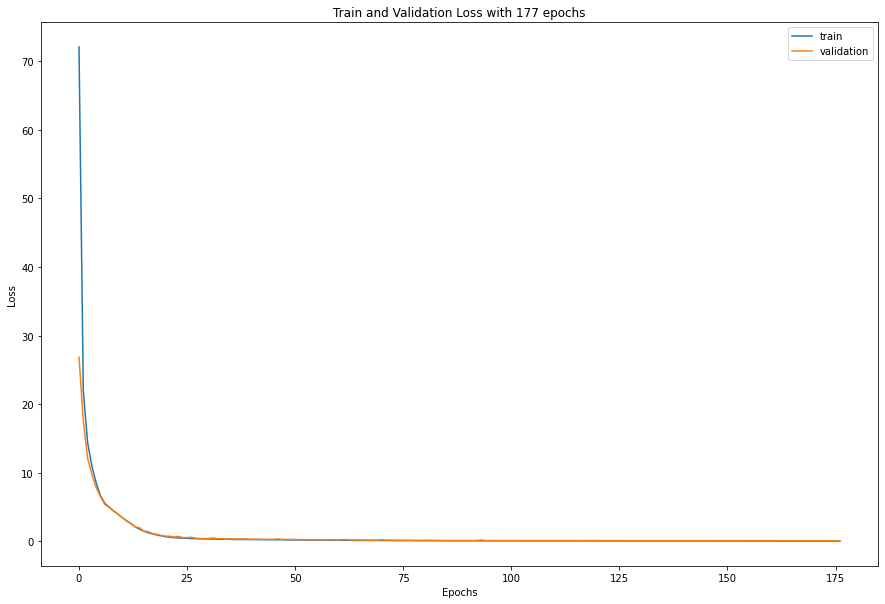

In [23]:
patience=25
# plot training and validation history
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+' epochs')
plt.legend()
 
plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience))

In [24]:
predict1=np.zeros((82)) #82
predict1=predictions[-3]
    
predict2=np.zeros((82))
predict2=predictions[-2]
    
predict3=np.zeros((82))
predict3=predictions[-1]

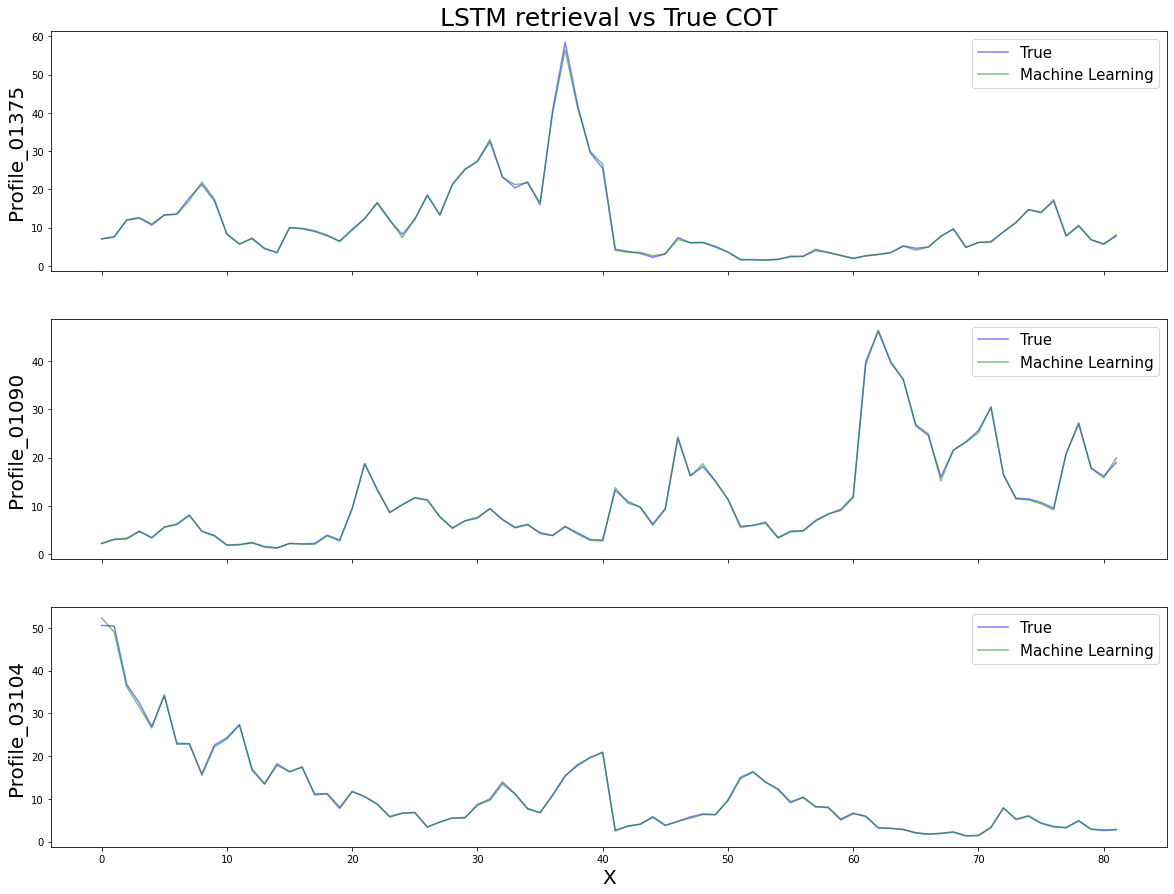

In [34]:
# plotting ---------------------------------------------------------------------------------------------------
fgnm = "plots/5folds_Bi-LSTM SZA=60 VZA=0 "+"_"+str(len(history.history['val_loss'])-patience)+'_epochs'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(20,15))

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"LSTM retrieval vs True COT", fontsize=25)
ax.plot(range(82),c[num-3],alpha=0.5,color="blue") #ground truth
ax.plot(range(82),predict1,alpha=0.5,color="green") 
ax.legend(["True", "Machine Learning"],fontsize=15)
ax.set_ylabel(r"Profile_01375",fontsize=20) 

#plot the second last profile
ax = axs[1]
ax.plot(range(82),c[num-2],alpha=0.5,color="blue")
ax.plot(range(82),predict2,alpha=0.5,color="green")
ax.legend(["True", "Machine Learning"],fontsize=15)
ax.set_ylabel(r"Profile_01090",fontsize=20)  

# plot the last profile
ax = axs[2]
ax.plot(range(82),c[num-1],alpha=0.5,color="blue")
ax.plot(range(82),predict3,alpha=0.5,color="green")
ax.legend(["True", "Machine Learning"],fontsize=15)
ax.set_ylabel(r"Profile_03104",fontsize=20)  
ax.set_xlabel('X', fontsize=20)

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')

In [27]:
cot=np.load('cot_500m.npy')

In [30]:
for i in range(4000):
    if np.array_equal(cot[i],c[num-1]):
        print(i+1)

3104


In [31]:
for i in range(4000):
    if np.array_equal(cot[i],c[num-2]):
        print(i+1)

1090


In [32]:
for i in range(4000):
    if np.array_equal(cot[i],c[num-3]):
        print(i+1)

1375


# Plotting across predicted 82 COT values

In [37]:
std=[]
mean=[]

for k in range(82):
    tmp=[]
    for j in range(test_size):
        tmp.append(np.abs(predictions[j][k]-test_label[j][k]))

    std.append(np.std(tmp))
    mean.append(np.mean(tmp))
std=np.array(std)
mean=np.array(mean)

In [38]:
len(mean)

82

In [39]:
len(std)

82

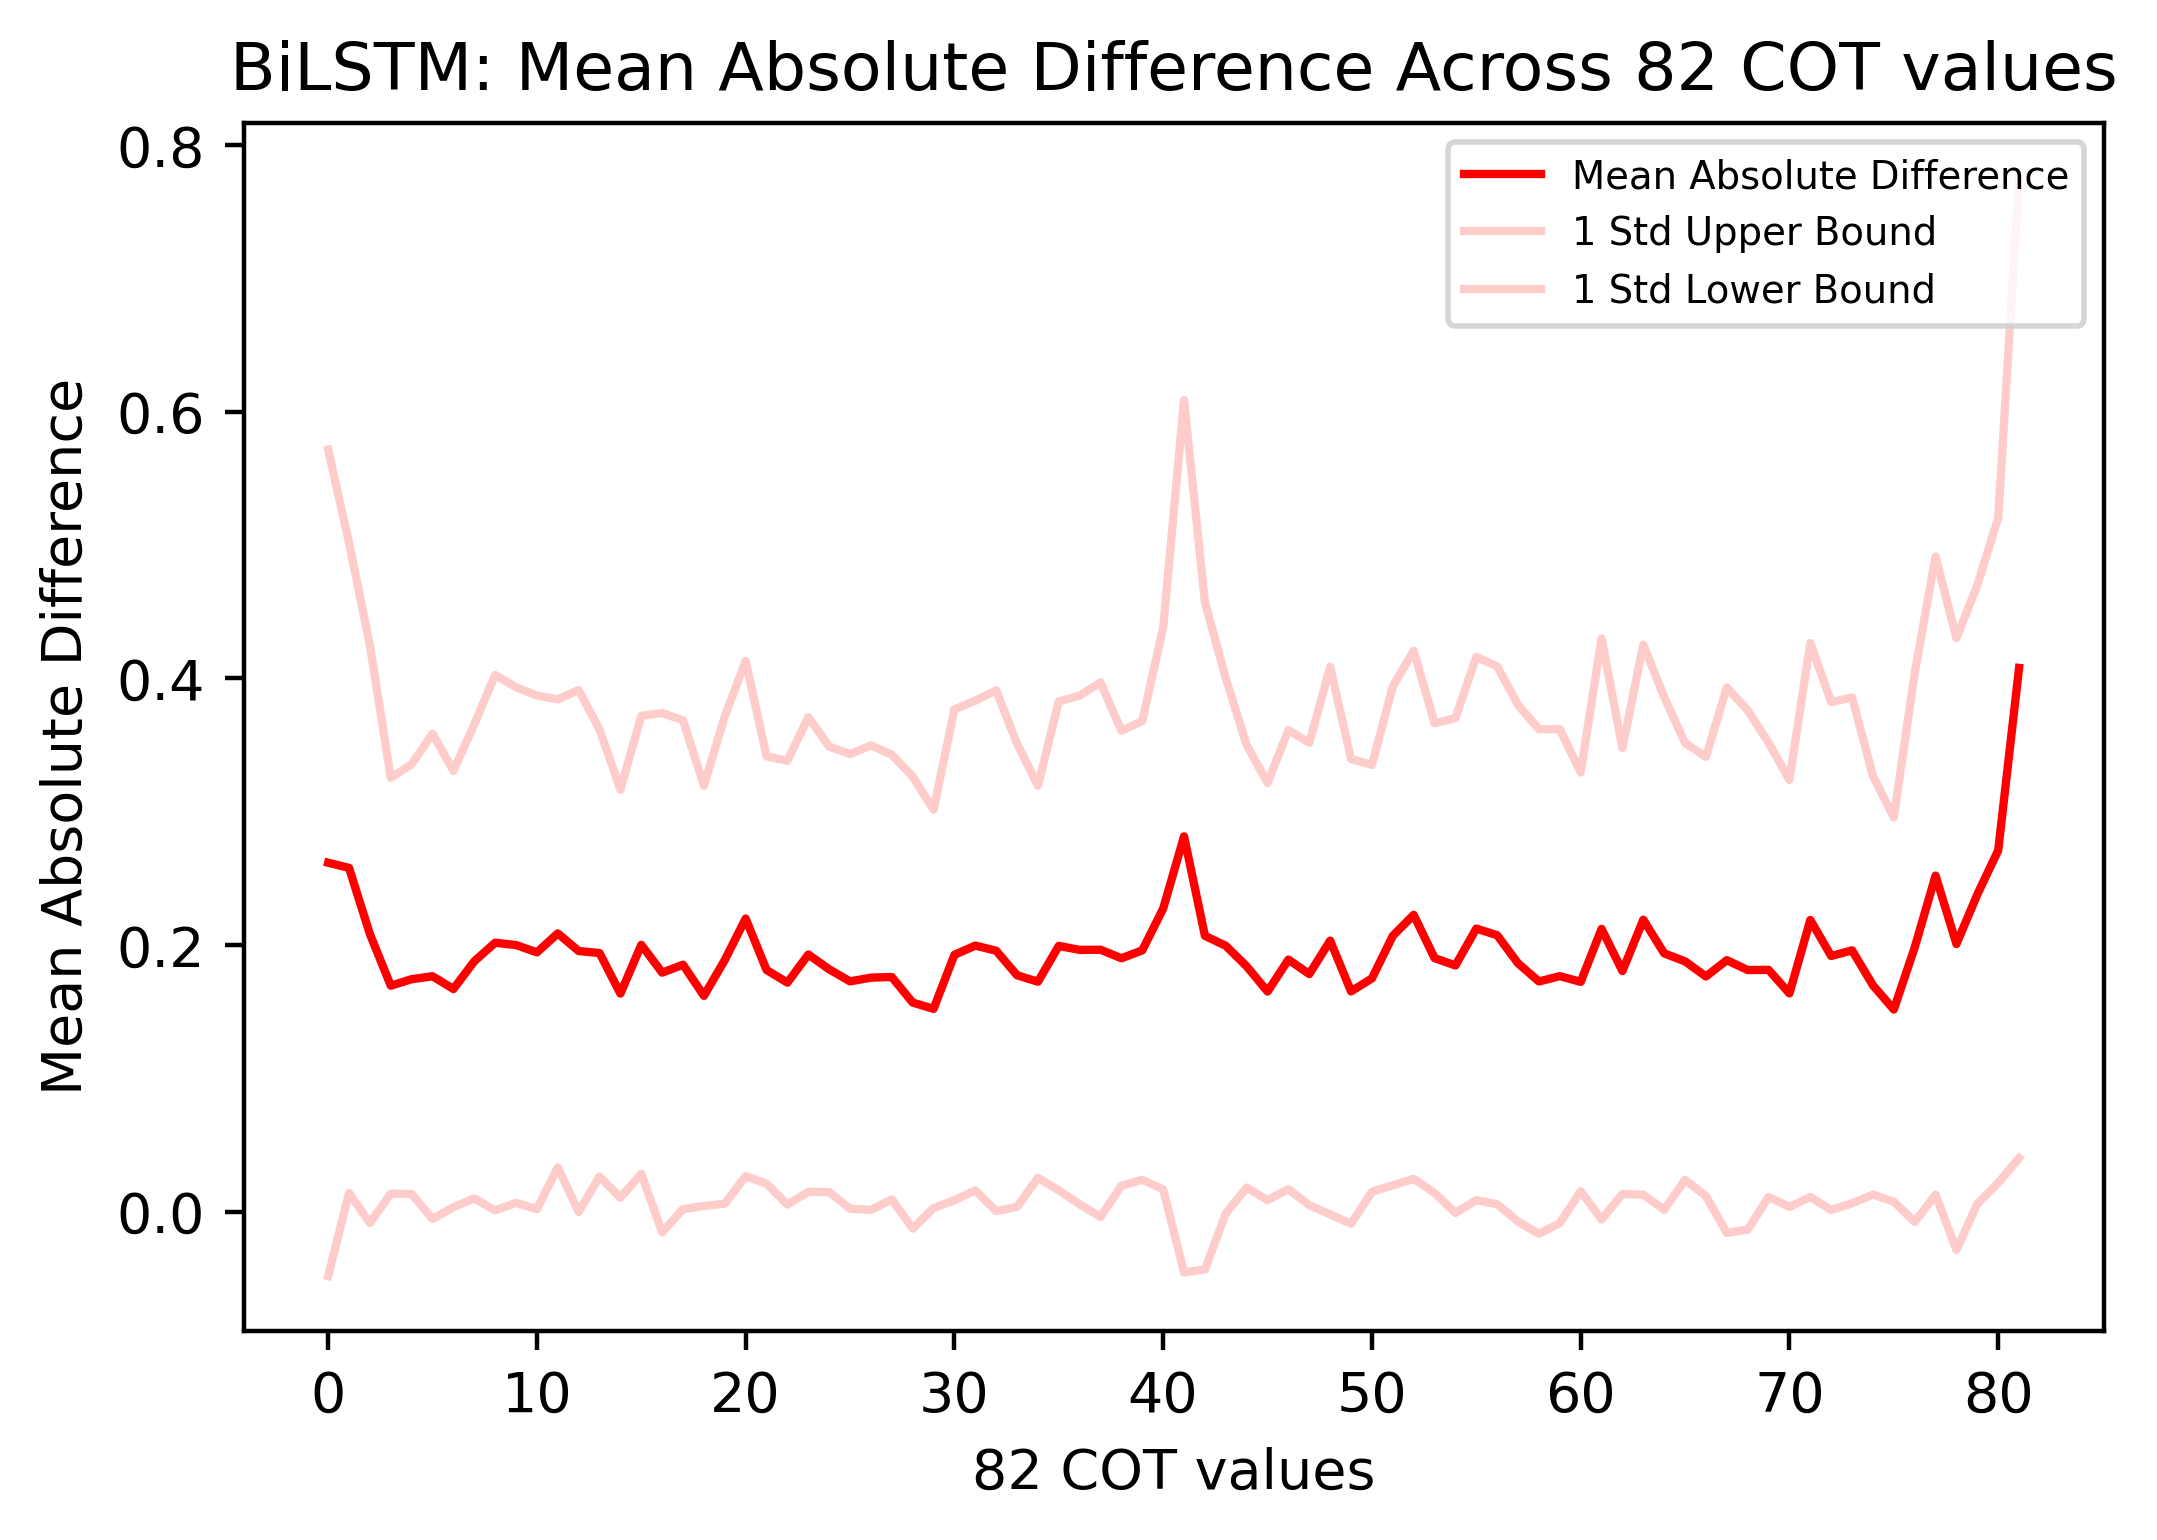

In [40]:
fig, ax = plt.subplots(dpi=400)
ax.plot(mean, '-r', label='Mean Absolute Difference')
ax.plot(mean+std, '-r', label='1 Std Upper Bound',alpha=0.2)
ax.plot(mean-std, '-r', label='1 Std Lower Bound',alpha=0.2)
ax.set_ylabel('Mean Absolute Difference ')  
ax.set_xlabel('82 COT values')

leg = ax.legend(loc=1,fontsize='x-small')
plt.title("BiLSTM: Mean Absolute Difference Across 82 COT values")

plt.savefig('plots/v1-BiLSTM_SZA=60_VZA=0_MeanAbsoluteDifferenceAcross82COTvalues.png',dpi=400)